# Exercise 1.4: Taxonomies of Complexity

In this notebook, we'll explore different ways to classify and measure complexity. These taxonomies help us understand the various dimensions of complex systems and provide frameworks for comparing systems across different domains.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns
from IPython.display import HTML
from itertools import product
import warnings
warnings.filterwarnings('ignore')

## Major Taxonomies of Complexity

Several frameworks exist for classifying complexity. We'll implement metrics for some of the most important ones:

1. **Structural Complexity**: Complexity in the system's organization or architecture
2. **Dynamic Complexity**: Complexity in the system's behavior over time
3. **Computational Complexity**: Difficulty in simulating or predicting the system
4. **Informational Complexity**: Information content or processing in the system

## 1. Structural Complexity Measures

### 1.1 Network-Based Complexity

Networks provide a powerful framework for measuring structural complexity. Let's create some example networks with different complexity levels:

In [2]:
def calculate_network_metrics(G):
    """Calculate various complexity metrics for a network."""
    metrics = {}
    
    # Basic metrics
    metrics['nodes'] = G.number_of_nodes()
    metrics['edges'] = G.number_of_edges()
    metrics['avg_degree'] = np.mean([d for n, d in G.degree()])
    
    # Connectedness
    try:
        metrics['diameter'] = nx.diameter(G)
    except:
        metrics['diameter'] = np.nan  # Not connected
    
    # Clustering
    metrics['clustering'] = nx.average_clustering(G)
    
    # Component analysis
    components = list(nx.connected_components(G))
    metrics['num_components'] = len(components)
    
    # Centrality measures
    centrality = nx.degree_centrality(G)
    metrics['centrality_std'] = np.std(list(centrality.values()))
    
    # Modularity using community detection
    if metrics['nodes'] > 2:  # Need enough nodes
        try:
            communities = nx.algorithms.community.greedy_modularity_communities(G)
            metrics['num_communities'] = len(communities)
        except:
            metrics['num_communities'] = 1
    else:
        metrics['num_communities'] = 1
        
    # Calculate network complexity index (composite metric)
    metrics['complexity_index'] = (metrics['clustering'] * 
                                  np.log(1 + metrics['avg_degree']) * 
                                  metrics['centrality_std'] * 
                                  np.log(1 + metrics['num_communities']))
    
    return metrics

In [3]:
# Create networks with different structures
networks = {
    'Random': nx.erdos_renyi_graph(30, 0.1),
    'Small-World': nx.watts_strogatz_graph(30, 4, 0.2),
    'Scale-Free': nx.barabasi_albert_graph(30, 2),
    'Hierarchical': nx.balanced_tree(2, 4),  # Binary tree with depth 4
    'Regular': nx.random_regular_graph(4, 30)  # Each node has exactly 4 connections
}

# Calculate metrics for each network
network_results = {}
for name, G in networks.items():
    network_results[name] = calculate_network_metrics(G)

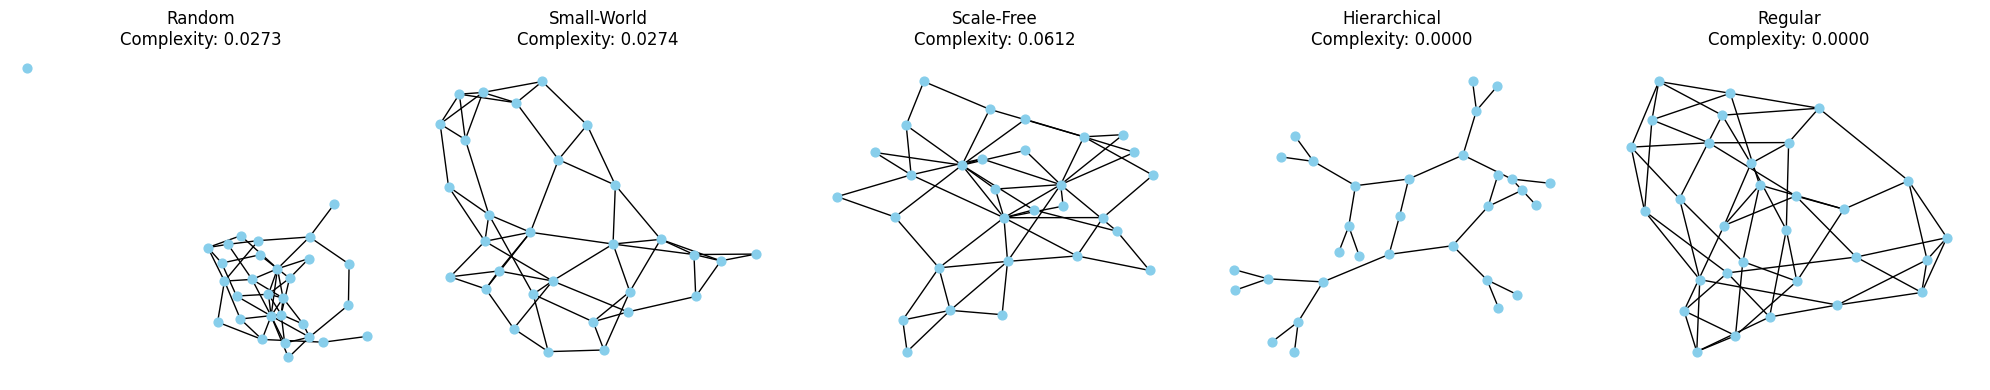

In [4]:
# Plot the networks side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (name, G) in enumerate(networks.items()):
    ax = axes[i]
    pos = nx.spring_layout(G, seed=42)  # Position nodes using force-directed layout
    nx.draw_networkx(G, pos=pos, ax=ax, node_size=40, with_labels=False, node_color='skyblue')
    ax.set_title(f"{name}\nComplexity: {network_results[name]['complexity_index']:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Create a comparison table
metrics_df = pd.DataFrame(network_results).T
selected_metrics = ['avg_degree', 'clustering', 'centrality_std', 'num_communities', 'complexity_index']
metrics_df[selected_metrics].round(4)

,avg_degree,clustering,centrality_std,num_communities,complexity_index
Random,3.4667,0.1398,0.0671,6.0,0.0273
Small-World,4.0000,0.3067,0.0345,4.0,0.0274
Scale-Free,3.7333,0.2944,0.0830,4.0,0.0612
Hierarchical,1.9355,0.0000,0.0327,5.0,0.0000
Regular,4.0000,0.1333,0.0000,4.0,0.0000


This analysis shows that different network structures exhibit different types of complexity. Scale-free networks typically show high heterogeneity in node connections (high centrality_std), while small-world networks have high clustering coefficients. Our composite complexity index attempts to capture these different dimensions.

## 2. Dynamic Complexity Measures

Dynamic complexity refers to the complexity of a system's behavior over time. Let's compare different time series using complexity measures.

In [6]:
def generate_time_series(type, n=1000, params=None):
    """Generate different types of time series."""
    np.random.seed(42)  # For reproducibility
    
    if type == 'random':
        # White noise
        return np.random.randn(n)
    
    elif type == 'sine':
        # Simple sine wave
        t = np.linspace(0, 10*np.pi, n)
        return np.sin(t)
    
    elif type == 'composite':
        # Multiple sine waves
        t = np.linspace(0, 10*np.pi, n)
        return np.sin(t) + 0.5*np.sin(2.5*t) + 0.25*np.sin(5*t)
    
    elif type == 'chaotic':
        # Logistic map (chaotic regime)
        r = 3.9  # Chaotic regime
        x = np.zeros(n)
        x[0] = 0.5  # Initial condition
        for i in range(1, n):
            x[i] = r * x[i-1] * (1 - x[i-1])
        return x
    
    elif type == 'ar':
        # Autoregressive process
        ar_params = params if params else [0.7, -0.3]
        return stats.arma_generate_sample(ar_params, [0], n)
    
    else:
        raise ValueError(f"Unknown time series type: {type}")

In [7]:
def calculate_dynamic_complexity(time_series):
    """Calculate various dynamic complexity measures for a time series."""
    metrics = {}
    
    # Basic statistics
    metrics['mean'] = np.mean(time_series)
    metrics['std'] = np.std(time_series)
    
    # Entropy measures
    # Convert to discrete bins for entropy calculation
    bins = np.linspace(min(time_series), max(time_series), 30)
    digitized = np.digitize(time_series, bins)
    values, counts = np.unique(digitized, return_counts=True)
    probabilities = counts / len(digitized)
    metrics['entropy'] = -np.sum(probabilities * np.log2(probabilities))
    
    # Autocorrelation-based measures
    autocorr = np.correlate(time_series - np.mean(time_series), 
                           time_series - np.mean(time_series), 
                           mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0]  # Normalize
    
    # Decay rate of autocorrelation
    metrics['autocorr_10'] = autocorr[10] if len(autocorr) > 10 else 0
    
    # Find first crossing of zero
    zero_crossings = np.where(np.diff(np.signbit(autocorr)))[0]
    metrics['decorrelation_time'] = zero_crossings[0] if len(zero_crossings) > 0 else len(autocorr)
    
    # Lyapunov Exponent approximation (simplified)
    # Only meaningful for deterministic systems
    n = len(time_series) - 1
    epsilon = np.std(time_series) / 100
    d0 = np.abs(np.diff(time_series))
    metrics['lyapunov_approx'] = np.mean(np.log(np.maximum(d0, epsilon))) / np.log(2)
    
    # Approximate Kolmogorov complexity
    # Using compression ratio as a proxy
    import zlib
    # Convert to bytes for compression
    data_bytes = str(list(digitized)).encode()
    compressed = zlib.compress(data_bytes)
    metrics['kolmogorov_approx'] = len(compressed) / len(data_bytes)
    
    # Multi-scale entropy (simplified)
    # We'll use sample entropy at different scales
    scales = [1, 5, 10]
    mse = []
    for scale in scales:
        # Coarse-graining process
        coarse_grained = np.array([np.mean(time_series[i:i+scale]) 
                                 for i in range(0, len(time_series)-scale+1, scale)])
        # Recalculate entropy
        bins_cg = np.linspace(min(coarse_grained), max(coarse_grained), 20)
        digitized_cg = np.digitize(coarse_grained, bins_cg)
        values_cg, counts_cg = np.unique(digitized_cg, return_counts=True)
        probabilities_cg = counts_cg / len(digitized_cg)
        entropy_cg = -np.sum(probabilities_cg * np.log2(probabilities_cg + 1e-10))
        mse.append(entropy_cg)
    
    metrics['mse_ratio'] = mse[-1] / mse[0] if mse[0] > 0 else 0
    
    return metrics

In [8]:
# Generate different time series
time_series = {
    'Random Noise': generate_time_series('random', n=500),
    'Sine Wave': generate_time_series('sine', n=500),
    'Composite Wave': generate_time_series('composite', n=500),
    'Chaotic Map': generate_time_series('chaotic', n=500),
    'AR Process': generate_time_series('ar', n=500)
}

# Calculate complexity metrics
ts_results = {}
for name, ts in time_series.items():
    ts_results[name] = calculate_dynamic_complexity(ts)

AttributeError: module 'scipy.stats' has no attribute 'arma_generate_sample'

In [ ]:
# Plot the time series
fig, axes = plt.subplots(len(time_series), 1, figsize=(12, 10))

for i, (name, ts) in enumerate(time_series.items()):
    ax = axes[i]
    ax.plot(ts)
    ax.set_title(f"{name} - Entropy: {ts_results[name]['entropy']:.2f}, "
                f"K-Complexity: {ts_results[name]['kolmogorov_approx']:.2f}")
    ax.set_xlim(0, 200)  # Show just a portion for better visibility
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Create comparison table
ts_df = pd.DataFrame(ts_results).T
selected_ts_metrics = ['entropy', 'decorrelation_time', 'lyapunov_approx', 'kolmogorov_approx', 'mse_ratio']
ts_df[selected_ts_metrics].round(4)

The table shows how different metrics capture different aspects of dynamic complexity:

- **Shannon Entropy**: Measures the unpredictability of the time series
- **Decorrelation Time**: How quickly the system "forgets" its past
- **Lyapunov Approximation**: Measures sensitivity to initial conditions (high for chaotic systems)
- **Kolmogorov Complexity**: Algorithmic complexity (approximated via compression)
- **Multi-scale Entropy Ratio**: How complexity changes across different time scales

No single measure fully captures all aspects of complexity. The chaotic map shows interesting properties: high Lyapunov exponent but lower entropy than pure noise.

## 3. Computational Complexity

Computational complexity focuses on the difficulty of simulating, predicting, or solving problems related to the system. Let's implement a simple example of computational complexity in cellular automata.

In [9]:
def run_elementary_ca(rule_number, size=100, steps=100, initial=None):
    """Run an elementary cellular automaton."""
    # Convert rule number to binary and pad to 8 bits
    rule_binary = format(rule_number, '08b')
    
    # Initialize grid
    grid = np.zeros((steps, size), dtype=int)
    if initial is None:
        # Start with a single cell in the middle
        grid[0, size//2] = 1
    else:
        grid[0] = initial
    
    # Run CA
    for i in range(1, steps):
        for j in range(size):
            # Get neighborhood with periodic boundary conditions
            left = grid[i-1, (j-1) % size]
            center = grid[i-1, j]
            right = grid[i-1, (j+1) % size]
            
            # Convert neighborhood to binary pattern
            pattern = (left << 2) | (center << 1) | right
            
            # Apply rule
            grid[i, j] = int(rule_binary[7 - pattern])
    
    return grid

In [10]:
def measure_ca_complexity(grid):
    """Measure computational complexity characteristics of CA evolution."""
    metrics = {}
    
    # Pattern complexity
    # Use compression as approximation of Kolmogorov complexity
    import zlib
    for i in range(min(10, grid.shape[0])):
        data_str = ''.join(map(str, grid[i]))
        compressed = zlib.compress(data_str.encode())
        metrics[f'row_{i}_compression_ratio'] = len(compressed) / len(data_str)
    
    # Growth of patterns
    # Count non-zero cells in each row
    active_cells = np.sum(grid, axis=1)
    metrics['final_active_cells'] = active_cells[-1]
    
    # Growth rate (linear fit to active cells)
    if np.any(active_cells):
        x = np.arange(len(active_cells))
        slope, _, _, _, _ = stats.linregress(x, active_cells)
        metrics['growth_rate'] = slope
    else:
        metrics['growth_rate'] = 0
        
    # Entropy evolution
    entropies = []
    for i in range(grid.shape[0]):
        values, counts = np.unique(grid[i], return_counts=True)
        probabilities = counts / grid.shape[1]
        entropy = -np.sum(probabilities * np.log2(probabilities))
        entropies.append(entropy)
    
    metrics['avg_entropy'] = np.mean(entropies)
    metrics['entropy_change'] = entropies[-1] - entropies[0] if entropies else 0
    
    # Final state entropy
    metrics['final_entropy'] = entropies[-1] if entropies else 0
    
    return metrics

In [11]:
# Run different CA rules and measure their complexity
ca_results = {}
ca_grids = {}

# Sample rules representing different Wolfram classes
rules = {
    'Class 1 (Rule 0)': 0,    # Evolution leads to homogeneous state
    'Class 2 (Rule 4)': 4,    # Evolution leads to simple periodic patterns
    'Class 3 (Rule 90)': 90,  # Evolution leads to chaotic patterns
    'Class 4 (Rule 110)': 110  # Evolution leads to complex patterns (computational universality)
}

for name, rule in rules.items():
    grid = run_elementary_ca(rule, size=100, steps=75)
    ca_grids[name] = grid
    ca_results[name] = measure_ca_complexity(grid)

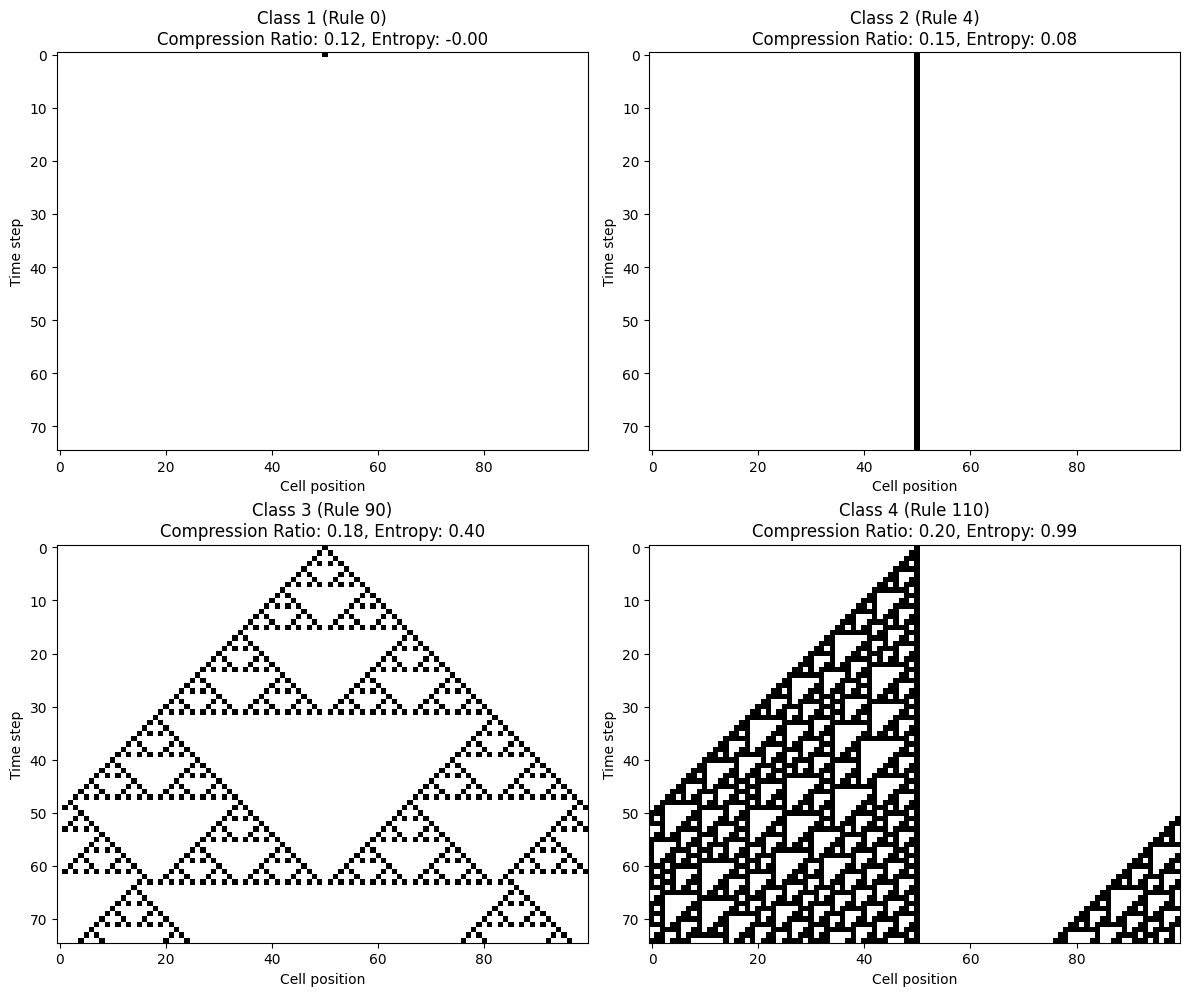

In [12]:
# Plot the CA evolutions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, grid) in enumerate(ca_grids.items()):
    ax = axes[i]
    ax.imshow(grid, cmap='binary', interpolation='none')
    ax.set_title(f"{name}\nCompression Ratio: {ca_results[name]['row_9_compression_ratio']:.2f}, "
                f"Entropy: {ca_results[name]['final_entropy']:.2f}")
    ax.set_xlabel('Cell position')
    ax.set_ylabel('Time step')

plt.tight_layout()
plt.show()

In [13]:
# Create comparison table
ca_df = pd.DataFrame(ca_results).T
selected_ca_metrics = ['row_9_compression_ratio', 'avg_entropy', 'growth_rate', 'final_entropy']
ca_df[selected_ca_metrics].round(4)

,row_9_compression_ratio,avg_entropy,growth_rate,final_entropy
Class 1 (Rule 0),0.12,0.0011,-0.0011,-0.0000
Class 2 (Rule 4),0.15,0.0808,0.0000,0.0808
Class 3 (Rule 90),0.18,0.4171,0.1235,0.4022
Class 4 (Rule 110),0.20,0.6909,0.5615,0.9928


This analysis shows how Wolfram's four classes of cellular automata exhibit different computational complexity:

1. **Class 1**: Evolve to a homogeneous state, quickly becoming highly compressible with low entropy
2. **Class 2**: Evolve to simple, stable or periodic structures - moderately compressible
3. **Class 3**: Evolve to chaotic patterns with high entropy but relatively predictable statistics
4. **Class 4**: Evolve to complex patterns with localized structures - these can support computation (Rule 110 is Turing complete!)

Class 4 automata are particularly interesting because they sit at the "edge of chaos" - between order and disorder - where computational complexity is highest.

## 4. Integrated Example: Placing Systems in Complexity Space

Now let's combine different metrics to place various systems in a "complexity space" to classify them:

In [14]:
# Create synthetic data representing different systems
np.random.seed(42)

# Define metrics for our "complexity space"
# 1. Number of components
# 2. Interaction density
# 3. Entropy
# 4. Predictability (inverse)

systems_data = {
    'Pendulum': [3, 0.9, 0.1, 0.9],  # Few components, high interaction, low entropy, highly predictable
    'Double Pendulum': [6, 0.8, 0.7, 0.3],  # More components, high interaction, higher entropy, less predictable
    'Weather System': [100, 0.6, 0.8, 0.2],  # Many components, medium interaction, high entropy, low predictability
    'Crystal': [1000, 0.1, 0.1, 0.9],  # Many components, low interaction, low entropy, highly predictable
    'Gas': [1000, 0.1, 0.9, 0.4],  # Many components, low interaction, high entropy, moderate predictability
    'Ecosystem': [500, 0.4, 0.7, 0.3],  # Many components, medium interaction, high entropy, low predictability
    'Brain': [800, 0.7, 0.8, 0.2],  # Many components, high interaction, high entropy, low predictability
    'Society': [700, 0.5, 0.8, 0.1],  # Many components, medium interaction, high entropy, very low predictability
    'Computer': [500, 0.3, 0.3, 0.8],  # Many components, low-medium interaction, low entropy, high predictability
    'Random Network': [50, 0.5, 0.9, 0.2]  # Medium components, medium interaction, high entropy, low predictability
}

# Add some random noise to make the visualization more interesting
for system, values in systems_data.items():
    systems_data[system] = [v + np.random.normal(0, 0.05) for v in values]
    # Clip to valid range
    systems_data[system] = [max(0, min(1, v)) for v in values]

# Convert to DataFrame
systems_df = pd.DataFrame(systems_data).T
systems_df.columns = ['Num_Components', 'Interaction_Density', 'Entropy', 'Predictability']

# Normalize number of components to 0-1 scale
systems_df['Num_Components'] = systems_df['Num_Components'] / systems_df['Num_Components'].max()

In [15]:
# Calculate composite complexity measures
systems_df['Structural_Complexity'] = systems_df['Num_Components'] * systems_df['Interaction_Density']
systems_df['Dynamic_Complexity'] = systems_df['Entropy'] * (1 - systems_df['Predictability'])
systems_df['Total_Complexity'] = (systems_df['Structural_Complexity'] + systems_df['Dynamic_Complexity']) / 2

# Sort by total complexity
systems_df.sort_values('Total_Complexity', ascending=False)

,Num_Components,Interaction_Density,Entropy,Predictability,Structural_Complexity,Dynamic_Complexity,Total_Complexity
Brain,1.0,0.7,0.8,0.2,0.7,0.64,0.670
Double Pendulum,1.0,0.8,0.7,0.3,0.8,0.49,0.645
Weather System,1.0,0.6,0.8,0.2,0.6,0.64,0.620
Society,1.0,0.5,0.8,0.1,0.5,0.72,0.610
Random Network,1.0,0.5,0.9,0.2,0.5,0.72,0.610
Pendulum,1.0,0.9,0.1,0.9,0.9,0.01,0.455
Ecosystem,1.0,0.4,0.7,0.3,0.4,0.49,0.445
Gas,1.0,0.1,0.9,0.4,0.1,0.54,0.320
Computer,1.0,0.3,0.3,0.8,0.3,0.06,0.180
Crystal,1.0,0.1,0.1,0.9,0.1,0.01,0.055


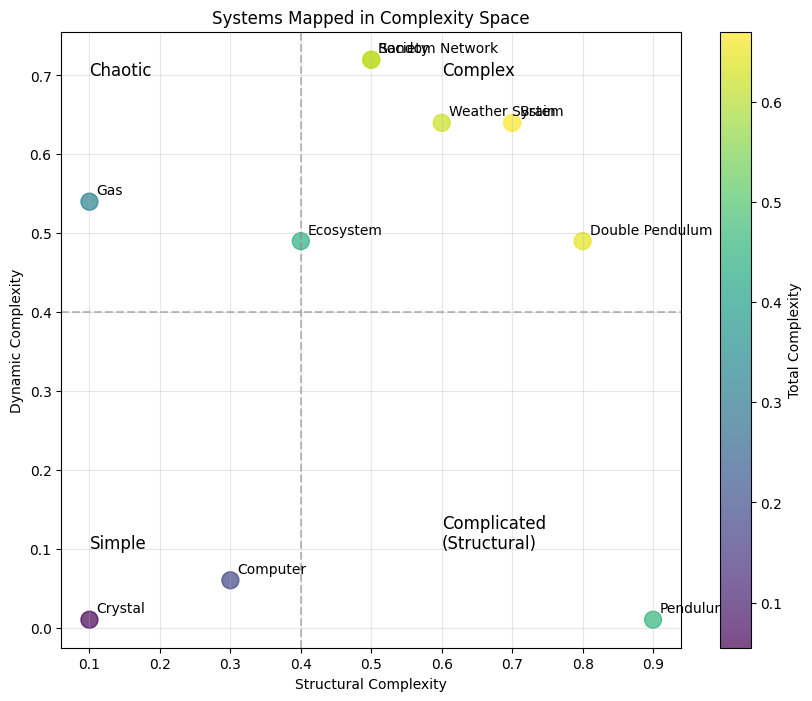

In [16]:
# Plot systems in the complexity space
plt.figure(figsize=(10, 8))

# Plot as scatter plot
scatter = plt.scatter(systems_df['Structural_Complexity'], 
                     systems_df['Dynamic_Complexity'],
                     c=systems_df['Total_Complexity'],
                     s=150,
                     alpha=0.7,
                     cmap='viridis')

# Add labels for each point
for i, txt in enumerate(systems_df.index):
    plt.annotate(txt, 
                (systems_df['Structural_Complexity'].iloc[i], systems_df['Dynamic_Complexity'].iloc[i]),
                xytext=(5, 5), 
                textcoords='offset points')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Total Complexity')

# Add dividing lines to create quadrants
plt.axhline(0.4, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0.4, color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
plt.text(0.1, 0.1, "Simple", fontsize=12)
plt.text(0.6, 0.1, "Complicated\n(Structural)", fontsize=12)
plt.text(0.1, 0.7, "Chaotic", fontsize=12)
plt.text(0.6, 0.7, "Complex", fontsize=12)

plt.xlabel('Structural Complexity')
plt.ylabel('Dynamic Complexity')
plt.title('Systems Mapped in Complexity Space')
plt.grid(True, alpha=0.3)
plt.show()

This visualization places different systems in a complexity space defined by:

- **Structural Complexity**: Combination of number of components and their interaction density
- **Dynamic Complexity**: Combination of entropy and unpredictability

The space divides into four quadrants representing different types of systems:

1. **Simple**: Low structural and dynamic complexity (e.g., pendulum, crystal)
2. **Complicated**: High structural but low dynamic complexity (e.g., computer)
3. **Chaotic**: Low structural but high dynamic complexity (e.g., gas)
4. **Complex**: High structural and dynamic complexity (e.g., brain, society, ecosystem)

This demonstrates how we can build a taxonomy of complexity that allows us to classify and compare systems across different domains.

## Your Turn: Classifying Real-World Systems

Implement a function that takes textual descriptions of systems and attempts to place them in the complexity space based on key characteristics. You'll need to extract features related to structural and dynamic complexity.

In [ ]:
def classify_system_complexity(description):
    """Analyze a system description and estimate its complexity metrics.
    
    Parameters:
    - description: Text description of the system
    
    Returns:
    - Dictionary with estimated complexity metrics
    """
    # TODO: Implement a method to extract complexity metrics from descriptions
    # You could use:  
    # 1. Keyword counting (e.g., words like "many", "interact", "predict", "random")
    # 2. Text analysis to estimate component count, interaction patterns, etc.
    # 3. Classification based on similar systems in our database
    
    # Example implementation (placeholder):
    metrics = {
        'Num_Components': 0.5,  # Normalized 0-1
        'Interaction_Density': 0.5,
        'Entropy': 0.5,
        'Predictability': 0.5
    }
    
    # Calculate derived measures
    metrics['Structural_Complexity'] = metrics['Num_Components'] * metrics['Interaction_Density']
    metrics['Dynamic_Complexity'] = metrics['Entropy'] * (1 - metrics['Predictability'])
    metrics['Total_Complexity'] = (metrics['Structural_Complexity'] + metrics['Dynamic_Complexity']) / 2
    
    return metrics